In [1]:
# Exports QuantumCollocation, NamedTrajectories, and TrajectoryIndexingUtils
using Piccolo
using LinearAlgebra

# Plots
using CairoMakie

In [2]:
const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units

const n_qubits = 1
const n_levels = 2

t_f = 50 * ns
n_steps = 101
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
Δt = times[2] - times[1]

0.5

In [3]:
# Operators
Paulis = Dict(
    "I" => Matrix{ComplexF64}(I, 2, 2),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 -im; im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)
Rx(theta)  = kron(Paulis["I"],exp(-im * theta * Paulis["X"]/2))
Ry(theta)  = kron(Paulis["I"],exp(-im * theta * Paulis["Y"]/2))
Rz(theta)  =  kron(Paulis["I"],exp(-im * theta * Paulis["Z"]/2))

Rz (generic function with 1 method)

In [4]:
a = [0 1; 0 0]
ad = transpose(a)
a0  = kron(a,Paulis["I"])
ad0  = kron(ad,Paulis["I"])
a1  = kron(Paulis["I"],a)
ad1  = kron(Paulis["I"],ad)

4×4 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 1.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im  0.0+0.0im

In [5]:
H_drift = [ ]
H_drives = [
    ad0 * a0,
    ad1 * a1,
    a0+ad0,
    im * (a0-ad0),
    a1+ad1,
    im * (a1-ad1),
    ad0 * a1 + a0 * ad1
]
system = QuantumSystem(H_drives)

QuantumSystem{Float64}([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0; 1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 -0.0 0.0 0.0], [0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0], [0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 -0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0]], [[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0; -1.0 0.0 0.0 0.0; 0.0 -1.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.

In [6]:
target=Rx(pi/2)

4×4 Matrix{ComplexF64}:
 0.707107+0.0im            0.0-0.707107im  …       0.0+0.0im
      0.0-0.707107im  0.707107+0.0im               0.0+0.0im
      0.0+0.0im            0.0+0.0im               0.0-0.707107im
      0.0+0.0im            0.0+0.0im          0.707107+0.0im

In [7]:
PICO_max_iter = 500

# Shape the cost function with weights on states and controls
Q = 100.
R = .5

# Add control bounds
a_bound = 2 * π * 500 * MHz
dda_bound = .01

problem = UnitarySmoothPulseProblem(
    system,
    target,
    n_steps,
    Δt;
    a_bound=a_bound,
    dda_bound=dda_bound,
    Q=Q,
    R=R,
    verbose=true,
    hessian_approximation=false,
    pade_order=10,
    free_time=false,
    timesteps_all_equal=true,
    subspace=[1, 2,3,4],
    max_iter=PICO_max_iter,
)

    building dynamics from integrators...
        constructing knot point dynamics functions...
        determining dynamics derivative structure...
            computing jacobian sparsity...
            computing full hessian block...
            creating full trajectory jacobian structure...
            creating full trajectory hessian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(54) … MOI.VariableIndex(5248) MOI.VariableIndex(5301); MOI.VariableIndex(2) MOI.VariableIndex(55) … MOI.VariableIndex(5249) MOI.VariableIndex(5302); … ; MOI.VariableIndex(52) MOI.VariableIndex(105) … MOI.VariableIndex(5299) MOI.VariableIndex(5352); MOI.VariableIndex(53) MOI.VariableIndex(106) … MOI.VariableIndex(5300) MOI.VariableIndex(5353)], QuantumSystem{Float64}([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0; 1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 -0.0 0.0 0.0], [0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0], [0.0 0.0 0.0 0.0; -0.0 0.0 0.

In [8]:
solve!(problem)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    77306
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   565621

Total number of variables............................:     5307
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1400
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4600
Total number of inequality c

  78  2.2221660e+02 3.67e+00 1.39e+02  -1.0 5.05e+00   2.1 3.03e-04 1.50e-03h  1
  79  2.2159444e+02 3.67e+00 1.55e+02  -1.0 3.52e+00   2.5 1.94e-03 1.49e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.2124550e+02 3.66e+00 1.74e+02  -1.0 5.63e+00   2.0 2.09e-03 8.82e-04h  1
  81  2.2037474e+02 3.66e+00 1.83e+02  -1.0 3.33e+00   2.5 2.35e-03 2.08e-03h  1
  82  2.1990162e+02 3.65e+00 1.70e+02  -1.0 1.25e+01   2.0 9.05e-04 1.33e-03h  1
  83  2.1949087e+02 3.65e+00 1.74e+02  -1.0 3.54e+00   2.4 1.12e-03 9.78e-04h  1
  84  2.1904862e+02 3.64e+00 3.90e+02  -1.0 3.54e+00   2.8 3.32e-03 1.06e-03h  1
  85  2.1854280e+02 3.64e+00 3.75e+02  -1.0 3.90e+00   2.4 5.31e-04 1.19e-03h  1
  86  2.1797890e+02 3.63e+00 3.75e+02  -1.0 3.66e+00   2.8 1.35e-03 1.34e-03h  1
  87  2.1727421e+02 3.63e+00 3.62e+02  -1.0 3.94e+00   2.3 1.08e-03 1.68e-03f  1
  88  2.1708658e+02 3.63e+00 3.93e+02  -1.0 3.59e+00   2.7 8.73e-04 4.55e-04h  1
  89  2.1682973e+02 3.62e+00

 171  1.8877772e+02 3.36e+00 2.79e+03  -1.0 4.33e+00   2.9 7.81e-04 2.19e-03f  1
 172  1.8869334e+02 3.36e+00 2.87e+03  -1.0 4.20e+00   3.3 3.35e-04 2.40e-04h  1
 173  1.8839872e+02 3.36e+00 2.81e+03  -1.0 4.77e+00   2.8 6.34e-04 9.03e-04h  1
 174  1.8825928e+02 3.36e+00 3.15e+03  -1.0 4.30e+00   3.3 9.29e-04 4.04e-04h  1
 175  1.8776990e+02 3.35e+00 3.12e+03  -1.0 5.55e+00   2.8 6.80e-04 1.53e-03h  1
 176  1.8772908e+02 3.35e+00 3.47e+03  -1.0 4.62e+00   3.2 9.34e-04 1.18e-04h  1
 177  1.8741230e+02 3.35e+00 3.49e+03  -1.0 6.30e+00   2.7 7.29e-05 1.02e-03f  1
 178  1.8723374e+02 3.35e+00 3.52e+03  -1.0 4.37e+00   3.1 6.33e-04 5.17e-04h  1
 179  1.8721560e+02 3.35e+00 3.48e+03  -1.0 6.43e+00   2.7 1.18e-03 6.34e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.8686612e+02 3.34e+00 3.41e+03  -1.0 4.37e+00   3.1 7.45e-04 1.02e-03h  1
 181  1.8682077e+02 3.34e+00 3.90e+03  -1.0 4.68e+00   3.5 6.20e-04 1.32e-04h  1
 182  1.8649680e+02 3.34e+00

 264  1.7154003e+02 3.20e+00 1.14e+04  -1.0 4.75e+00   3.7 4.91e-04 1.41e-05h  1
 265  1.7147698e+02 3.20e+00 1.15e+04  -1.0 4.44e+00   4.1 1.91e-04 1.82e-04h  1
 266  1.7115291e+02 3.19e+00 1.14e+04  -1.0 4.79e+00   3.6 8.86e-04 9.08e-04h  1
 267  1.7113277e+02 3.19e+00 1.19e+04  -1.0 4.63e+00   4.0 1.45e-04 5.79e-05h  1
 268  1.7104947e+02 3.19e+00 1.18e+04  -1.0 4.98e+00   3.6 1.54e-04 2.26e-04h  1
 269  1.7101241e+02 3.19e+00 1.20e+04  -1.0 4.49e+00   4.0 1.69e-04 1.04e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.7092071e+02 3.19e+00 1.21e+04  -1.0 4.73e+00   3.5 3.14e-04 2.43e-04f  1
 271  1.7065987e+02 3.19e+00 1.15e+04  -1.0 4.34e+00   3.9 5.62e-04 7.33e-04h  1
 272  1.7033578e+02 3.19e+00 1.10e+04  -1.0 4.95e+00   3.5 1.08e-04 8.58e-04h  1
 273  1.7019100e+02 3.18e+00 1.01e+04  -1.0 4.10e+00   3.9 4.98e-05 4.15e-04h  1
 274  1.7015405e+02 3.18e+00 1.01e+04  -1.0 6.94e+00   3.4 3.64e-04 9.77e-05h  1
 275  1.7013309e+02 3.18e+00

 357  3.5447438e+01 9.04e-01 1.70e+02  -1.0 1.30e+00   2.7 1.07e-02 1.10e-02h  1
 358  3.5503127e+01 8.99e-01 1.68e+02  -1.0 1.69e+00   2.2 5.11e-03 5.30e-03h  1
 359  3.5516824e+01 8.96e-01 2.98e+02  -1.0 1.25e+00   2.6 9.65e-03 4.07e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  3.5612565e+01 8.93e-01 3.34e+02  -1.0 3.06e+00   2.2 1.23e-03 3.63e-03f  1
 361  3.5631988e+01 8.89e-01 4.01e+02  -1.0 1.29e+00   2.6 8.46e-03 4.16e-03h  1
 362  3.5670687e+01 8.88e-01 3.58e+02  -1.0 3.25e+00   2.1 4.08e-03 1.29e-03h  1
 363  3.5692385e+01 8.77e-01 2.63e+02  -1.0 1.27e+00   2.5 4.90e-03 1.23e-02h  1
 364  3.5748622e+01 8.67e-01 1.91e+02  -1.0 1.16e+00   3.0 9.74e-03 1.13e-02h  1
 365  3.5780600e+01 8.60e-01 1.64e+02  -1.0 1.25e+00   2.5 5.01e-03 8.18e-03h  1
 366  3.5848461e+01 8.50e-01 1.27e+02  -1.0 1.12e+00   2.9 8.25e-03 1.12e-02h  1
 367  3.5888029e+01 8.46e-01 1.15e+02  -1.0 1.31e+00   2.4 5.54e-03 4.41e-03h  1
 368  3.5914257e+01 8.42e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  4.0335026e+01 6.00e-01 4.41e+03  -1.0 1.00e+00   3.5 3.44e-03 2.40e-03h  1
 451  4.0343969e+01 6.00e-01 4.34e+03  -1.0 1.05e+00   3.0 2.71e-03 6.45e-04h  1
 452  4.0344179e+01 6.00e-01 4.86e+03  -1.0 9.72e-01   3.4 6.34e-03 4.16e-05h  1
 453  4.0441490e+01 5.90e-01 4.71e+03  -1.0 1.04e+00   2.9 1.15e-04 1.55e-02h  1
 454  4.0444485e+01 5.90e-01 4.67e+03  -1.0 9.78e-01   3.4 4.80e-03 3.31e-04h  1
 455  4.0493452e+01 5.88e-01 4.55e+03  -1.0 1.07e+00   2.9 7.36e-04 3.07e-03h  1
 456  4.0549691e+01 5.85e-01 4.44e+03  -1.0 9.79e-01   3.3 4.78e-03 5.82e-03h  1
 457  4.0562213e+01 5.84e-01 4.44e+03  -1.0 1.13e+00   2.8 2.84e-03 8.44e-04h  1
 458  4.0595993e+01 5.81e-01 4.52e+03  -1.0 9.96e-01   3.3 5.83e-03 4.87e-03h  1
 459  4.0650329e+01 5.79e-01 4.56e+03  -1.0 1.28e+00   2.8 6.37e-03 3.66e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  4.0653726e+01 5.79e-01

In [9]:
result = copy(problem.trajectory)

NamedTrajectory{Float64}([1.0 0.9999961552246156 … 0.3685212595708673 0.3879602219549885; 0.0 2.422881169647508e-7 … 0.14477923266028772 0.10184705893831911; … ; 0.001495268869834056 0.009965288192773303 … 0.0003034849849987305 -1.816033113569637e-5; -0.009968000924372238 -0.009869361992427887 … -0.004802012973610357 -2.739991180673514e-6], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0  …  0.00961460860766029, -0.019504171102072525, 0.018178632856522655, 2.4477534757898722e-5, -2.111727181991798e-5, -1.6531784296836424e-5, 1.2756758063947611e-5, -1.3529415721423003e-6, -1.816033113569637e-5, -2.739991180673514e-6], 101, 0.5, 53, (Ũ⃗ = 32, a = 7, da = 7, dda = 7, states = 46, controls = 7), (a = ([-3.141592653589793, -3.141592653589793, -3.141592653589793, -3.141592653589793, -3.141592653589793, -3.141592653589793, -3.141592653589793], [3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793]), dda = ([-0.01

In [10]:
iso_vec_to_operator(result[:Ũ⃗][:, 1])

4×4 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  1.0+0.0im

In [11]:
states = map(iso_vec_to_operator, eachslice(result[:Ũ⃗], dims=2))

101-element Vector{Matrix{ComplexF64}}:
 [1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im]
 [0.9999961552246156 + 1.0536558294555268e-6im 1.2674158521441517e-6 - 0.001267509771608444im -1.3786648805347847e-8 - 1.5055037572665246e-6im 1.4788892684121486e-6 + 5.24028900813568e-7im; 2.422881169647508e-7 - 0.001261650576611894im 0.9999951261388941 + 8.873559972296178e-7im -9.190158020380703e-7 + 1.8735481838824698e-6im 1.1252022403007447e-6 - 2.3456085056889176e-6im; 6.977315241432321e-7 - 2.931199985682493e-6im 1.9022676662550077e-7 + 1.2101871946665732e-6im 0.9999958156805535 - 2.5278766317280507e-6im 1.0000579370570557e-6 - 0.0012679513179924657im; -1.9889946176232123e-6 + 1.328088068245559e-6im -3.1542611380297383e-7 - 1.2871114248864895e-6im -5.145211039184354e-7 - 0.001265971355193149im 0.9999970716551477 - 6.618471015223244e-7im]
 [1.0059

In [12]:
rollout_states = unitary_rollout(result, system; integrator=exp)

32×101 Matrix{Float64}:
 1.0  1.0   0.985232      0.969521    …  -0.114406    -0.0695152  -0.0610109
 0.0  0.0  -0.0932549    -0.105286        0.260006     0.213823    0.184334
 0.0  0.0   0.0827495     0.130281       -0.233064    -0.189825   -0.137551
 0.0  0.0  -0.00218062   -0.00950006      0.792427     0.796171    0.824943
 0.0  0.0   0.000470199   0.00546794     -0.0402421   -0.0602948  -0.0352912
 0.0  0.0   0.0631122     0.173273    …  -0.272932    -0.22486    -0.224164
 0.0  0.0  -0.0978528    -0.0330952      -0.341363    -0.390453   -0.407356
 0.0  0.0   0.0145121     0.0270422      -0.210732    -0.269955   -0.213106
 0.0  0.0   0.0975689     0.113408        0.135107     0.116268    0.126068
 1.0  1.0   0.982774      0.965712        0.543494     0.493592    0.408678
 0.0  0.0   0.0159122     0.0318444   …   0.164142     0.229355    0.231195
 0.0  0.0   0.0851703     0.122892        0.125066     0.175009    0.225063
 0.0  0.0   0.0599005     0.156646       -0.162273    -0.23806

In [13]:
# .- the dot applies the operation elementwise
ΔUs = map(norm, eachslice(rollout_states .- result[:Ũ⃗], dims=2))
maximum(ΔUs)

2.535890197096303

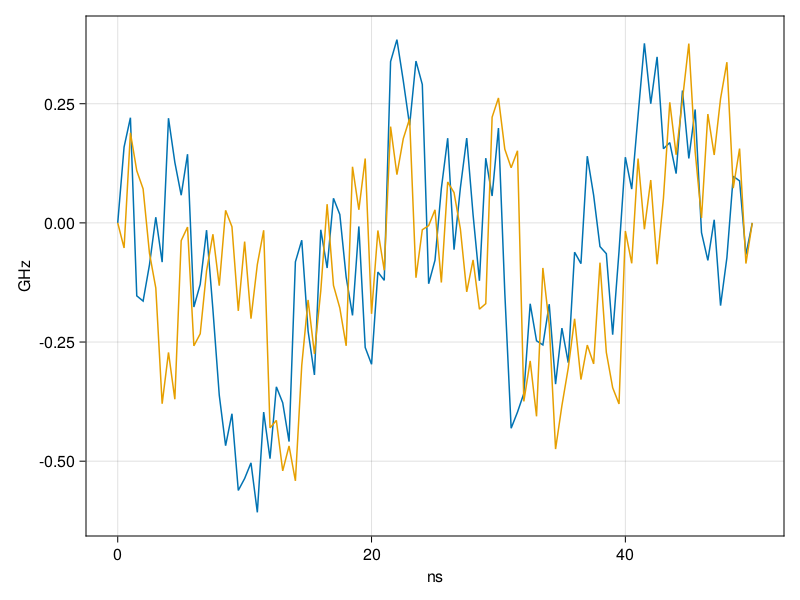

In [14]:
ts = accumulate(+, timesteps(result)) .- timesteps(result)[1]
as = result[:a]

f = Figure()
ax = Axis(f[1, 1], xlabel="ns", ylabel="GHz")

lines!(ax, ts, as[1, :], label="X")
lines!(ax, ts, as[2, :], label="Y")

f